<a href="https://colab.research.google.com/github/124c/strategy_reviews/blob/master/Pairs_trading_backtest_CM2013.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.tsa.vector_ar.vecm import coint_johansen
!pip install pandas-datareader
import pandas_datareader as web

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


Define a function to load free data from Yahoo Finance API

In [2]:
def get_prices(ticker, source, startDate, endDate, *args):
    if source == 'yahoo':
        try:
            result = web.DataReader(ticker, 'yahoo', startDate, endDate,)
            # TODO: add multiindex on columns if multiple columns chosen
            if len(args) > 0:
              result = result[[x for x in args]]

              result.columns = ticker
        except KeyError:
            print('may be wrong ticker name')
            result = None
        except Exception:
            print(Exception)
            result = None
    return result

Now define cointegration tests

In [3]:
def run_adfuller_test(Spread):
    '''
    run cointegration test if there are more than 100 observations
    H0: that there is a unit root -> no stationarity
    H1: there is no unit root -> stationary
    pval > threshold value: cannot reject H0'''
    if len(Spread) >= 100:
        '''settings for regression testing:
        https://www.statsmodels.org/dev/generated/statsmodels.tsa.stattools.adfuller.html
        here we assume no time trend in time series and no drift for simplicity!'''
        return float(sm.tsa.adfuller(x=Spread)[1])  # ,regression='ctt'
    else:
        return np.nan

def trace_results(statistic, crit_vals):
    trace_res = list(statistic > crit_vals)
    if trace_res == [True, True, True]:
        # print('reject 0 coint. relationships, 99pct confidence')
        return 'coint exists'
    if trace_res == [True, True, False]:
        # print('reject 0 coint. relationships, 95pct confidence')
        return 'coint exists'
    if trace_res == [True, False, False]:
        # print('reject 0 coint. relationships, 90pct confidence')
        return 'coint rejected'
    if trace_res == [False, False, False]:
        # print('cannot reject 0 coint. relationships')
        return 'coint rejected'

def run_johansen_test(data):
    result = coint_johansen(data, det_order=0, k_ar_diff=1)
    """r = 0 means no cointegration, r<=1 means up to one cointegration relationship etc
    We have m hypothesised numbers of cointegrated equations: here at most 0, at most 1 
    cvt - Critical values (90%, 95%, 99%) of trace statistic
    lr1 - Trace statistic
    Trace test:
    H0: 0 cointegration equations
    H1: coint. eq. exist > 0 
    explanation https://www.youtube.com/watch?v=TB4m9M1sIJ0
    """
    stat_r0 = result.lr1[0]
    crits_r0 = result.cvt[0]
    # eig_stat_r0 = result.lr2[0]
    # eig_crits_r0 = result.cvm[0]
    stat_res = trace_results(stat_r0, crits_r0)  # there are 0 coint. equations. pass if rejected
    # eig_res = trace_results(eig_stat_r0, eig_crits_r0)  # there are 0 coint. equations. pass if rejected
    return stat_res

def run_engel_granger(ts1, ts2):
    '''H0: there is no cointegration
    H1: there is cointegration relationship
    pval < threshold value: reject H0
    time series are assumed to be integrated of order 1!!!'''
    return sm.tsa.coint(ts1, ts2, autolag='bic')[1]

Now define z-score and hedge ratio calculation

In [4]:
def get_OLS_spread(series1, series2):
    x_train = sm.add_constant(series2)
    model = sm.OLS(series1, x_train)
    result = model.fit()
    hedge_ratio = result.params[1]
    spread = series1 - series2 * hedge_ratio
    return spread, hedge_ratio

def zscore_std(series):
    return ((series - series.mean()) / np.std(series)).rename("z-score")

Let's write down trading logic

In [5]:
def check_open(current_zscore, long_thresh, short_thresh):
    return np.where(current_zscore < long_thresh, 1, np.where(current_zscore > short_thresh, -1, 0))
def check_close_long(current_zscore, close_thresh):
    return np.where(current_zscore > close_thresh, 0, 1)
def check_close_short(current_zscore, close_thresh):
    return np.where(current_zscore < close_thresh, 0, -1)

def trading_rule(current_position, current_zscore):
    if current_position == 0: # if no positions today, check if I should open one tomorrow
        position = check_open(current_zscore, -2, 2)
    if current_position == 1: # if long today, should I close it tomorrow
        position = check_close_long(current_zscore, -0.5)
    if current_position == -1: # the same here
        position = check_close_short(current_zscore, 0.75)
    return position

The last function definitions are for strategy analytics

In [6]:
def get_position_numbers(signal_list):
    posnums = [0]
    posnum = 0
    for i in range(1, len(signal_list)):
        if signal_list[i] == 0:
            posnums.append(0)
        else: # two cases: 11, 01, otherwise 0
            if signal_list[i-1] == 0:
                posnum+=1
            else:
                posnum+=0
            posnums.append(posnum)
    return posnums

def limit_position_time(signals, length):
    nums = [x for x in signals['position_numbers'].unique() if x !=0]
    for j in nums:
        otr_int = signals[signals['position_numbers']==j].index
        otr_length = len(otr_int)
        if otr_length > length:
            numbers = [j]*length + [0]*(otr_length - length)
            signals['position_numbers'].loc[otr_int[0]:otr_int[-1]] = numbers
    return signals

def get_log_returns(dataset, ticker1, ticker2, hedge_ratio):
    log_L = pd.Series(np.log(dataset[ticker1]))
    log_S = pd.Series(np.log(dataset[ticker2]))
    dataset['Log_L'] = log_L.diff()
    dataset['Log_S'] = log_S.diff()
    dataset['log_returns'] = np.where(dataset['positions'] == 1,
                                      dataset['Log_L'] - dataset['Log_S']*hedge_ratio,
                                      np.where(dataset['positions'] == -1,
                                               -1*(dataset['Log_L'] - dataset['Log_S']*hedge_ratio),
                                               0))
    dataset['simple_returns'] = np.exp(dataset['log_returns'])-1
    return dataset

def get_cross_section(signals, cost):
    trades = {}
    nums = [x for x in signals['position_numbers'].unique() if x !=0]
    for j in nums:
        trades[j] = signals[signals['position_numbers']==j]
        trades[j]['log_ret_cum'] = trades[j]['log_returns'].cumsum()
        costs = 2*np.log((1-cost)/(1+cost))
        trades[j]['log_ret_cum_after_costs'] = trades[j]['log_ret_cum'] + costs
    return trades

Now I'll define a class for fast and easy backtesting job

In [13]:
class backtest_pair:
    def __init__(self, ticker1, ticker2, start_time, end_time, long_open, short_open, long_close, short_close, costs):
        # settings
        self.ticker1 = ticker1
        self.ticker2 = ticker2
        self.long_open = long_open
        self.long_close = long_close
        self.short_open = short_open
        self.short_close = short_close
        self.costs = costs
        self.start_time = start_time
        self.end_time = end_time
        # data
        self.dataset = None
        self.spread = None
        self.spread_zscore = None
        self.hedge_ratio = None
        self.four_month_intervals = None
        self.start_trading_date = None
        self.trades = None
        # results
        self.returns = pd.DataFrame()
        self.spread_zscore = None

    def get_dataset(self):
        self.dataset = get_prices([self.ticker1, self.ticker2], 'yahoo',
                                     self.start_time, self.end_time, 'Adj Close').dropna()
        for i in ['Spread_zscore', 'positions', 'position_numbers', 'Log_L', 'Log_S', 'log_returns', 'simple_returns']:
            self.dataset[i] = np.nan

    def cut_4months(self):
        start = self.dataset.index[0]
        end = self.dataset.index[-1]
        self.four_month_intervals = pd.date_range(start, end, freq='4M')

    def start_trading_time(self):
        start = pd.to_datetime(self.start_time)
        self.start_trading_date = pd.to_datetime((start + pd.offsets.DateOffset(months=12)).date())

    def finalize_time_stamps(self):
        self.four_month_intervals = self.four_month_intervals[self.four_month_intervals>
                                                              self.start_trading_date]

    def perform_tests(self, data, zscore):
        EG = run_engel_granger(data[self.ticker1],#.pct_change().dropna(),
                               data[self.ticker2])#.pct_change().dropna())
        ADF = run_adfuller_test(zscore)
        Johansen = run_johansen_test(data.dropna())
        return EG, ADF, Johansen

    def calculate_spread(self, hedge_ratio, dataset):
        spread = dataset[self.ticker1] - dataset[self.ticker2] * hedge_ratio
        spread_zscore = zscore_std(spread)
        return spread_zscore, spread

    def insert_spread(self, hedge_ratio, dataset):
        spread_zscore, spread = self.calculate_spread(hedge_ratio, dataset)
        self.spread_zscore = pd.concat([self.spread_zscore, spread_zscore])

    def get_returns(self, hedge_ratio, dataset, trading):
        spread_zscore, spread = self.calculate_spread(hedge_ratio, dataset)
        # 0 - no position, 1 - long, -1 - short
        if trading == True:
            positions = [0]
            for i in range(1, len(spread_zscore)):
                current_position = positions[-1]  # today I look at active position that was set yestraday for today
                positions.append(trading_rule(current_position, spread_zscore[i]))
        if trading == False:
            positions = [0]*len(spread_zscore)

        signals = pd.DataFrame({str(self.ticker1): dataset[self.ticker1],
                                str(self.ticker2): dataset[self.ticker2],
                                'Spread_zscore': spread_zscore,
                                'positions': positions},
                               index=spread.index)
        signals['positions'] = signals['positions'].shift().fillna(0)
        signals['position_numbers'] = get_position_numbers(signals['positions'].tolist())
        signals = limit_position_time(signals, 50)  # simple limiter for positions longer than 50 days
        # I look at the data at the end of the day!
        # the trading decision comes in force next day!
        # trades = get_cross_section(signals)
        signals = get_log_returns(dataset=signals, ticker1=self.ticker1, ticker2=self.ticker2,
                                  hedge_ratio=hedge_ratio)

        # self.dataset = pd.concat([self.dataset, signals.iloc[:,2:]], axis=1)
        self.dataset.loc[signals.index] = signals
        # self.spread_zscore = pd.concat([self.spread_zscore, spread_zscore])

    def iterate(self):
        for i in self.four_month_intervals:
            start = pd.offsets.DateOffset(months=12)#.date()
            end = pd.offsets.DateOffset(months=4)#.date()
            training_set = self.dataset[[self.ticker1, self.ticker2]].loc[i-start:i]
            test_set = self.dataset[[self.ticker1, self.ticker2]].loc[i:i+end]
            # get historical spread + historical hedge ratio
            training_spread, hedge_ratio = get_OLS_spread(training_set[self.ticker1],
                                                          training_set[self.ticker2])
            training_spread_zscore = zscore_std(training_spread)
            EG, ADF, Johansen = self.perform_tests(training_set, training_spread_zscore)
            # print(EG, ADF, Johansen)
            print('tradng set: {}:{}, EG:{}, ADF:{}, Johansen:{}'.format(test_set.index[0].strftime('%Y-%m-%d'),
                                                                         test_set.index[-1].strftime('%Y-%m-%d'),
                                                                         round(EG, 3), round(ADF, 3), Johansen))
            if (EG <= 0.105) and (ADF <= 0.105) and (Johansen == 'coint exists'):
            # if (ADF <= 0.105):
                # print('tradng set', test_set.index[0], test_set.index[-1])
                self.get_returns(hedge_ratio=hedge_ratio, dataset=test_set, trading=True)
                # self.spread_zscore = pd.concat([self.spread_zscore, test_set])
            else:
                self.get_returns(hedge_ratio=hedge_ratio, dataset=test_set, trading=False)

        self.dataset['position_numbers'] = get_position_numbers(self.dataset['positions'].fillna(0).tolist())
        self.dataset = self.dataset.fillna(0)

    def get_trades_pl(self):
        self.trades = get_cross_section(self.dataset, self.costs)

    def visualize_trades_pl(self):
        f, ax = plt.subplots()
        [ax.plot(range(self.trades[x].shape[0]), self.trades[x]['log_ret_cum_after_costs'].values) for x in list(self.trades.keys())]

    def visualize_trades_pl_no_costs(self):
        f, ax = plt.subplots()
        [ax.plot(range(self.trades[x].shape[0]), self.trades[x]['log_ret_cum'].values) for x in list(self.trades.keys())]

    def visualize(self):
        fig, axs = plt.subplots(2, 1, gridspec_kw={'height_ratios': [3, 1]}, sharex=True)
        fig.suptitle('Positions and signals')
        axs[0].plot(self.dataset[self.ticker1], color='orange', label=self.ticker1, fillstyle='none')
        axs[0].plot(self.dataset[self.ticker2], color='blue', label=self.ticker2, fillstyle='none')
        axs[0].fill_between(self.dataset.index,
                            self.dataset[[self.ticker1, self.ticker2]].min().min(),
                            self.dataset[[self.ticker1, self.ticker2]].max().max(),
                            where=self.dataset['positions'] == 1,
                            facecolor='green', alpha=0.5,)
        axs[0].fill_between(self.dataset.index,
                            self.dataset[[self.ticker1, self.ticker2]].min().min(),
                            self.dataset[[self.ticker1, self.ticker2]].max().max(),
                            where=self.dataset['positions'] == -1,
                            facecolor='red', alpha=0.5,)
        axs[0].legend()
        axs[1].plot(self.dataset.index, self.dataset['Spread_zscore'].values)
        axs[1].fill_between(self.dataset.index,
                            self.dataset['Spread_zscore'].min(),
                            self.dataset['Spread_zscore'].max(),
                            where=self.dataset['positions'] == -1,
                            facecolor='red', alpha=0.5,)
        axs[1].fill_between(self.dataset.index,
                            self.dataset['Spread_zscore'].min(),
                            self.dataset['Spread_zscore'].max(),
                            where=self.dataset['positions'] == 1,
                            facecolor='green', alpha=0.5,)
        axs[1].axhline(self.long_open, color='green', lw=2, alpha=0.5)
        # axs[1].axhline(self.long_close, color='green', lw=2, alpha=0.5)
        axs[1].axhline(self.short_open, color='red', lw=2, alpha=0.5)
        # axs[1].axhline(self.short_close, color='red', lw=2, alpha=0.5)
        plt.show()


    def run(self):
        self.get_dataset() # load data from yahoo finance
        self.cut_4months() # cut dataset into 4 months period. Tests are performed each 4 months 
        self.start_trading_time() # time when backtesting starts. Training period is 1 year
        self.finalize_time_stamps() # timestamps define start of new testing period
        self.iterate() # iterate and backtest returns
        self.get_trades_pl() # get profit-loss from strategy trades

Class is not that hard as it seems. Besides, it's comfortable for backtesting. to run a backtest with new tickers, just type them into a class and use a .run() method. All set! Now you can compare and analyse strategy returns for any pair you want!

So the arguments for backtester are: 

1.   ticker1
2.   ticker2
3.  start time
4. end time
5. open threshold for long 
6. open threshold for short 
7. close threshold for long  
8. close threshold for short  
9. your expected comission 


Now let's backtest a strategy on a pasir from original paper


In [14]:
bt1 = backtest_pair('V', 'MA','2014-01-01','2020-09-01', -2, 2, -0.5, 0.75, 0.005)
bt1.run()

tradng set: 2015-02-02:2015-05-29, EG:0.004, ADF:0.006, Johansen:coint exists
tradng set: 2015-06-01:2015-09-30, EG:0.039, ADF:0.033, Johansen:coint rejected
tradng set: 2015-09-30:2016-01-29, EG:0.225, ADF:0.088, Johansen:coint exists
tradng set: 2016-02-01:2016-05-31, EG:0.888, ADF:0.729, Johansen:coint rejected
tradng set: 2016-05-31:2016-09-30, EG:0.706, ADF:0.537, Johansen:coint rejected
tradng set: 2016-09-30:2017-01-30, EG:0.194, ADF:0.071, Johansen:coint rejected
tradng set: 2017-01-31:2017-05-31, EG:0.368, ADF:0.17, Johansen:coint rejected
tradng set: 2017-05-31:2017-09-29, EG:0.747, ADF:0.517, Johansen:coint rejected
tradng set: 2017-10-02:2018-01-30, EG:0.544, ADF:0.303, Johansen:coint rejected
tradng set: 2018-01-31:2018-05-31, EG:0.01, ADF:0.051, Johansen:coint rejected
tradng set: 2018-05-31:2018-09-28, EG:0.177, ADF:0.095, Johansen:coint rejected
tradng set: 2018-10-01:2019-01-30, EG:0.179, ADF:0.065, Johansen:coint rejected
tradng set: 2019-01-31:2019-05-31, EG:0.127, A

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


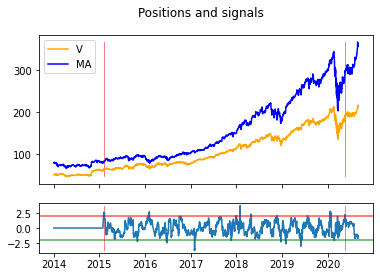

In [15]:
bt1.visualize()

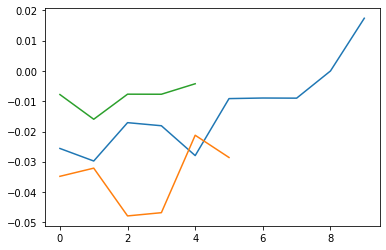

In [16]:
bt1.visualize_trades_pl()